# Capstone Project - The Battle of Neighborhoods assignment

## Introduction
New York city is an increasingly diverse and dynamic city with immigrants making up the majority of the residents in some neighborhoods. All five boroughs illustrate this melting pot of cultures through activities, museums, stores and restaurants, where you can meet people of different countries, sample exotic cuisine and products, listen to international music and watch foreign films. Being home to such diverse cultures, it is home to diverse culinary arts from different regions around the world.
There are many restaurants and food joints in NYC catering to different categories like Mexican, Indian, Chinese to name a few.
The goal of this project is to visualize parts of NYC where there is presence of Chinese cuisine restaurants.

## Data
For this project we need the following data :
New york city data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
We will also explore the number of Chinese restaraunts in each borough and neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Chinese restaurants.

## Approach
Collect the new york city data from https://cocl.us/new_york_dataset (https://cocl.us/new_york_dataset)
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are Chinese Resturants.



In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longit
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
print('Libraries imported.')

Libraries imported.


### Define a method to get the geolocation coordinates of a location using Nominatim in geopy library

In [3]:

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="nyc_useragent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Define a method to fetch venues within a radius of 1000 metres for a given latitude and longitude using the FourSquare API. 

In [4]:

def getVenues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'UTVXWTUKKREEZX24ZVTPUTYDPWMCMXEOZAUGZIZFNT4SNU5D' # your Foursquare ID
    CLIENT_SECRET = 'SBYAP3TXDOPBZ0SSJMXFBGBPQF5CYEWGPVMAHL2H324KYYCJ' # your Foursquare Secret
    VERSION = '20202601' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Define a method to fetch NYC neighborhood data using a given dataset

In [6]:
def fetchNewYorkData():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    newYorkDF = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        newYorkDF = newYorkDF.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return newYorkDF

### Invoke the method to fetch NYC neighborhood data in a dataframe

In [7]:

# get new york data
newYorkDF=fetchNewYorkData()
newYorkDF.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
newYorkDF.shape

(306, 4)

### Use a matlib plot to show the information about number of neighborhoods in each borough in New york city

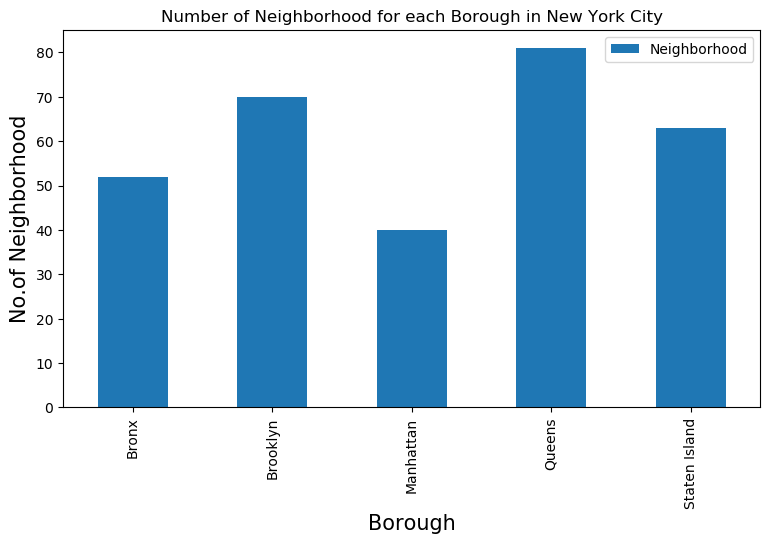

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
newYorkDF.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Define a method to search for a given category (in our use-case, we will pass the search criteria as Chinese restaurants). This method internally calls the getVenue method declared earlier

In [15]:
# prepare neighborhood list that contains indian resturants
def getSearchCategory(category):
    column_names=['Borough', 'Neighborhood', 'ID','Name']
    categorized_items_ny=pd.DataFrame(columns=column_names)
    count=1
    for row in newYorkDF.values.tolist():
        Borough, Neighborhood, Latitude, Longitude=row
        venues = getVenues(Latitude,Longitude)
        categorized_items=venues[venues['Category']== category]   
        print('(',count,'/',len(newYorkDF),')',category+' in '+Neighborhood+', '+Borough+':'+str(len(categorized_items)))
        for resturant_detail in categorized_items.values.tolist():
            id, name , category=resturant_detail
            categorized_items_ny = categorized_items_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name
                                                   }, ignore_index=True)
        count+=1
    return categorized_items_ny

### Invoke the getSearchCategory method by passing 'Chinese Restaurant' as the search criteria to get a dataframe of Chinese restaurants in per neighborhood and boroughs|

In [18]:
categorized_items_ny_df = getSearchCategory('Chinese Restaurant')
categorized_items_ny_df.shape

( 1 / 306 ) Chinese Restaurant in Wakefield, Bronx:3
( 2 / 306 ) Chinese Restaurant in Co-op City, Bronx:3
( 3 / 306 ) Chinese Restaurant in Eastchester, Bronx:1
( 4 / 306 ) Chinese Restaurant in Fieldston, Bronx:1
( 5 / 306 ) Chinese Restaurant in Riverdale, Bronx:0
( 6 / 306 ) Chinese Restaurant in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Restaurant in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Restaurant in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Restaurant in Norwood, Bronx:2
( 10 / 306 ) Chinese Restaurant in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Restaurant in Baychester, Bronx:3
( 12 / 306 ) Chinese Restaurant in Pelham Parkway, Bronx:5
( 13 / 306 ) Chinese Restaurant in City Island, Bronx:1
( 14 / 306 ) Chinese Restaurant in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Restaurant in University Heights, Bronx:1
( 16 / 306 ) Chinese Restaurant in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Restaurant in Fordham, Bronx:1
( 18 / 306 ) Chinese Restaurant in East Tremont, Bronx:

(400, 4)

### Use the categorized restaurant items dataframe to plot a graph that shows number of Chiness restaurants per borough  

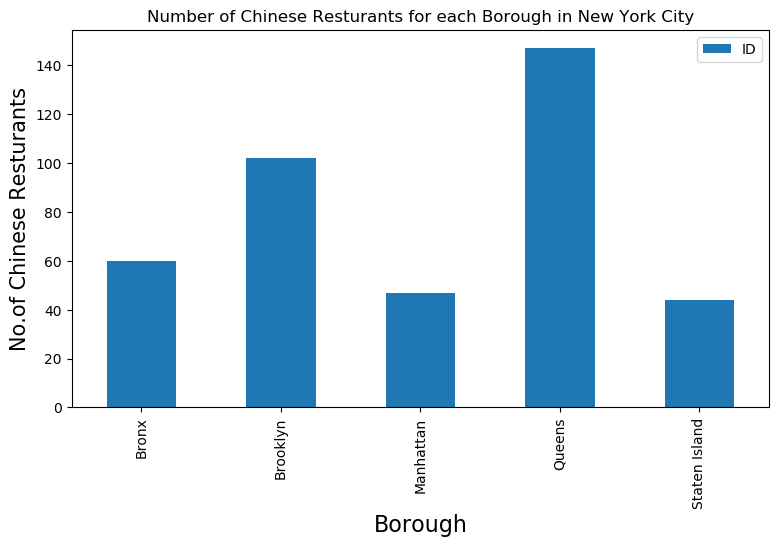

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 16)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
categorized_items_ny_df.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

###  Use the categorized restaurant items dataframe to plot a graph that shows number of Chiness restaurants per neighborhood  

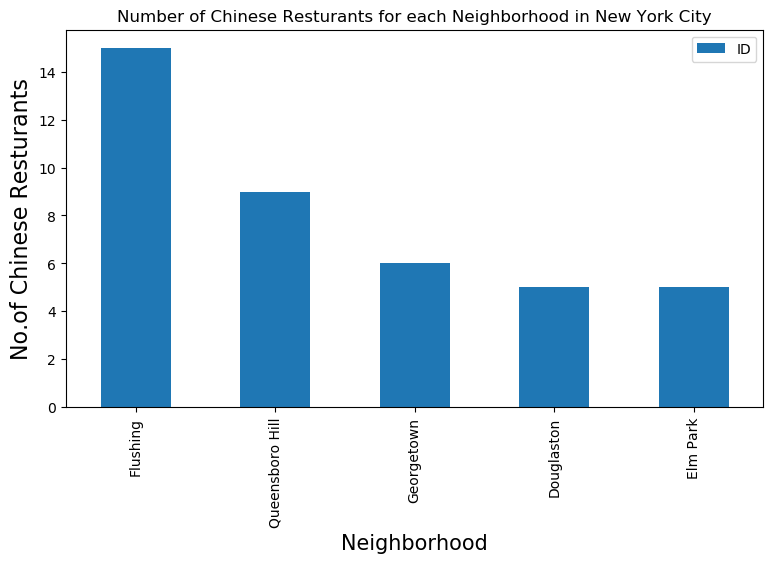

In [20]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=16)
#giving a bar plot
categorized_items_ny_df.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

# Conclusion
Queens borough has the most number of CHinese restaurants followed by Broklyn, Bronx, Staten Island and Manhattan.
Flushing followed by Queensboro Hill, Georgetown, Douglaston and Elm park are the neighborhoods which has the most number of Chinese restaurants

### Further scope
We could further use the new york city dataset alongwith foursquare apis to figure out the ratings, tips of the restaurants in various neighborhoods. This would help us to determine which neighborhood could be the best if you are looking for a Chinse cuisine.